In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import log_loss, make_scorer

import xgboost as xgb

import optuna

# Input data files are avail hyyable in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

sns.set()

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


## Helper functions

In [2]:
# p = {'max_depth': 7,
#  'min_child_weight': 3,
#  'learning_rate': 0.09481013111513892,
#  'subsample': 0.6,
#  'colsample_bytree': 0.10287736645803192}


def days_to_years(df, columns):
    return df[columns].apply(lambda x: x / 365.25)


def get_cv_score(X, y, params=None):    
    if params:
        estimator = xgb.XGBClassifier(**params)
    else:
        estimator = xgb.XGBClassifier()
        
    sampler = StratifiedKFold(n_splits=5)
    scorer = make_scorer(log_loss, greater_is_better=True, needs_proba=True)
    return cross_val_score(estimator, X, y, cv=sampler, scoring=scorer)


def tuning_xgb(X, y):
    
    def objective(trial):
        xgb_params = {
            "n_estimators": 100,
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_int("min_child_weight", 0, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
            "subsample": trial.suggest_float("subsample", 0.1, 1, step=0.1),
            "colsample_bytree": trial.suggest_float('colsample_bytree', 0.1, 1),
#             "reg_alpha": trial.suggest_float('reg_alpha', 0, 1),
        }
        
        scores = get_cv_score(X, y, params=xgb_params)
        return scores.mean()
        
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    return study
    

# Import the data

In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e26/train.csv", index_col='id')
test_df = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv", index_col='id')

In [4]:
print(train_df.info(),test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status       

## Transform Age and N_Days columns

In [5]:
eda_data = train_df.copy()
eda_data[['N_Days', 'Age']] = days_to_years(eda_data, ['N_Days', 'Age'])

# Work with categorical columns

In [6]:
eda_cat_features = eda_data.select_dtypes('object')
print(eda_cat_features.head(),'\n')
print("Categorical columns: ",eda_cat_features.columns,'\n')


#Unique values of each feature
uniques = eda_cat_features.apply(pd.unique)
print("Unique Values", uniques, sep='\n')

               Drug Sex Ascites Hepatomegaly Spiders Edema Status
id                                                               
0   D-penicillamine   M       N            N       N     N      D
1           Placebo   F       N            N       N     N      C
2           Placebo   F       N            Y       Y     Y      D
3           Placebo   F       N            N       N     N      C
4           Placebo   F       N            Y       N     N      C 

Categorical columns:  Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status'], dtype='object') 

Unique Values
Drug            [D-penicillamine, Placebo]
Sex                                 [M, F]
Ascites                             [N, Y]
Hepatomegaly                        [N, Y]
Spiders                             [N, Y]
Edema                            [N, Y, S]
Status                          [D, C, CL]
dtype: object


## Plot train data categories distribution

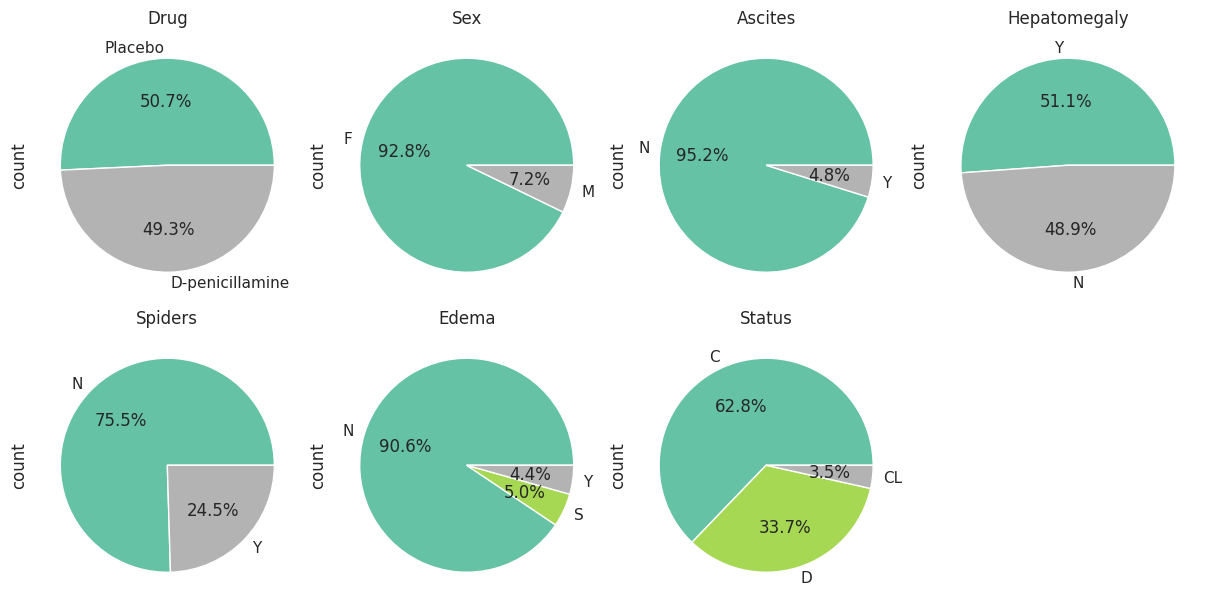

In [7]:
#distribution charts
fig = plt.figure(figsize=(12,6), layout='constrained')

for i, col in enumerate(eda_cat_features.columns, 1):
    fig.add_subplot(2,4,i)
    eda_cat_features[col].value_counts().plot.pie(title=col, autopct="%.1f%%", colormap='Set2')
    
    

## Plot test data categories distribution

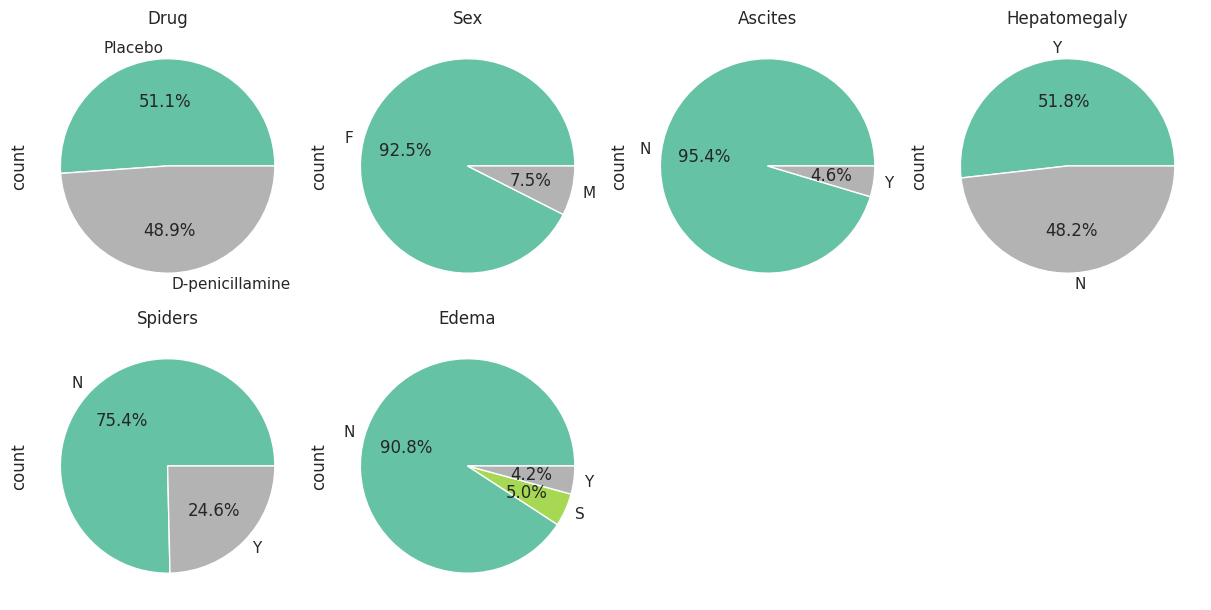

In [8]:
#distribution charts
test_cat_features = test_df.select_dtypes('object')
fig = plt.figure(figsize=(12,6), layout='constrained')

for i, col in enumerate(test_cat_features.columns, 1):
    fig.add_subplot(2,4,i)
    test_cat_features[col].value_counts().plot.pie(title=col, autopct="%.1f%%", colormap='Set2')
    

## Some specific plots

<Axes: title={'center': 'Drag usage to Status'}, xlabel='Status'>

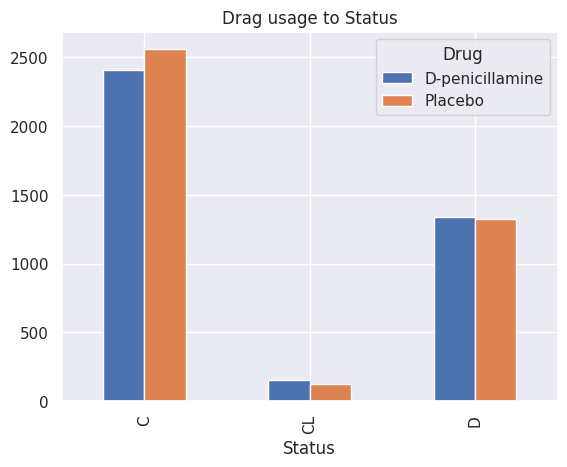

In [9]:
eda_cat_features.groupby(['Status', 'Drug'])['Drug'].value_counts().unstack().plot.bar(title='Drag usage to Status')

<Axes: title={'center': 'Hepatomegaly relation to status'}, xlabel='Status'>

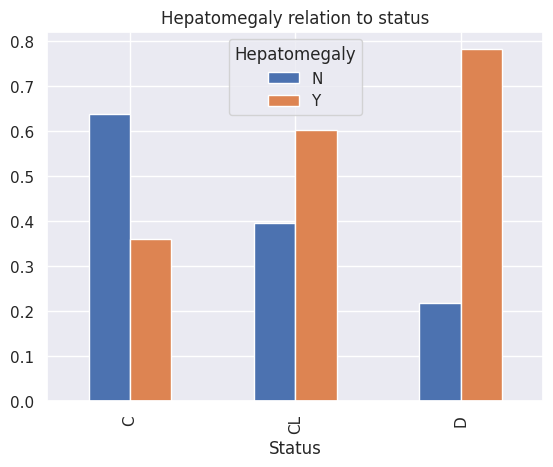

In [10]:
eda_cat_features.groupby(['Status'])['Hepatomegaly'].value_counts(normalize=True).unstack().plot.bar(title='Hepatomegaly relation to status')

## Work with numerical columns

In [11]:
eda_num_features = eda_data.select_dtypes(np.number)
# print(eda_num_features.head())
print(eda_num_features.columns)
eda_num_features.describe()

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000
mean,5.558312,50.302934,2.594485,350.561923,3.548323,83.902846,1816.745250,114.604602,115.340164,265.228969,10.629462,3.032511
std,2.995849,10.075178,3.812960,195.379344,0.346171,75.899266,1903.750657,48.790945,52.530402,87.465579,0.781735,0.866511
min,0.112252,26.277892,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,3.367556,42.639288,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,211.000000,10.000000,2.000000
50%,5.013005,51.233402,1.100000,298.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,10.600000,3.000000
75%,7.362081,56.629706,3.000000,390.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,13.127995,78.439425,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,18.000000,4.000000


## Plot train data numerical distributions

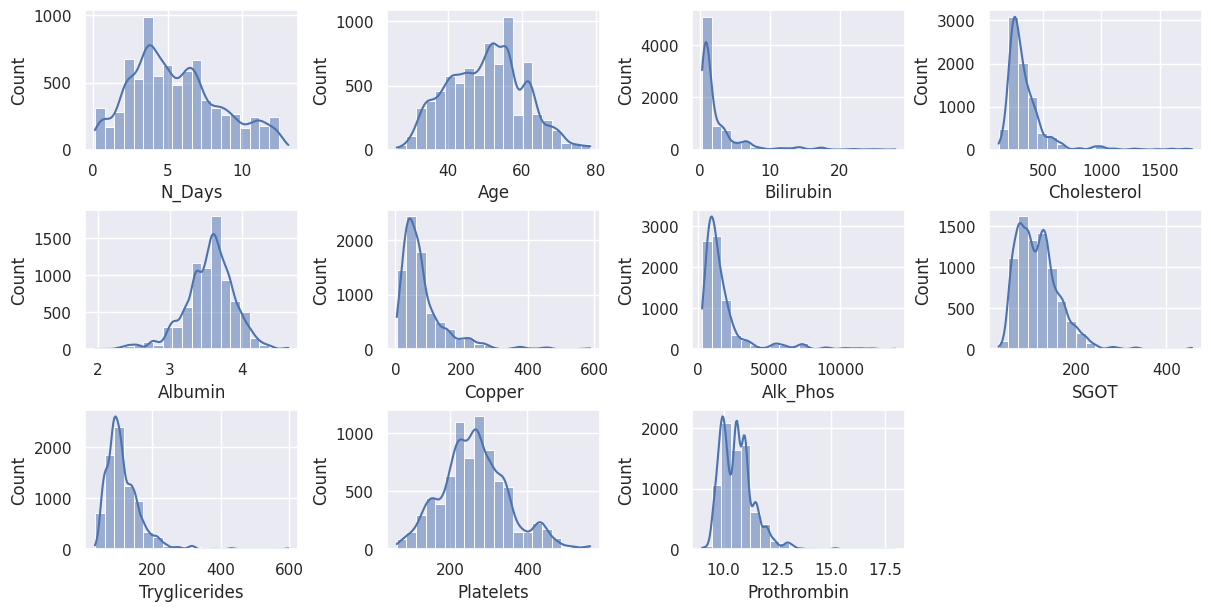

In [12]:
#plot all num features except Stage because it is ordinal feature and it will be treated later
fig = plt.figure(figsize=(12,6), layout='constrained')
for i, col in enumerate(eda_num_features.iloc[:, :-1], 1):
    fig.add_subplot(3,4,i)
    sns.histplot(eda_num_features[col], bins=20, kde=True)


## Plot test data numerical distributions

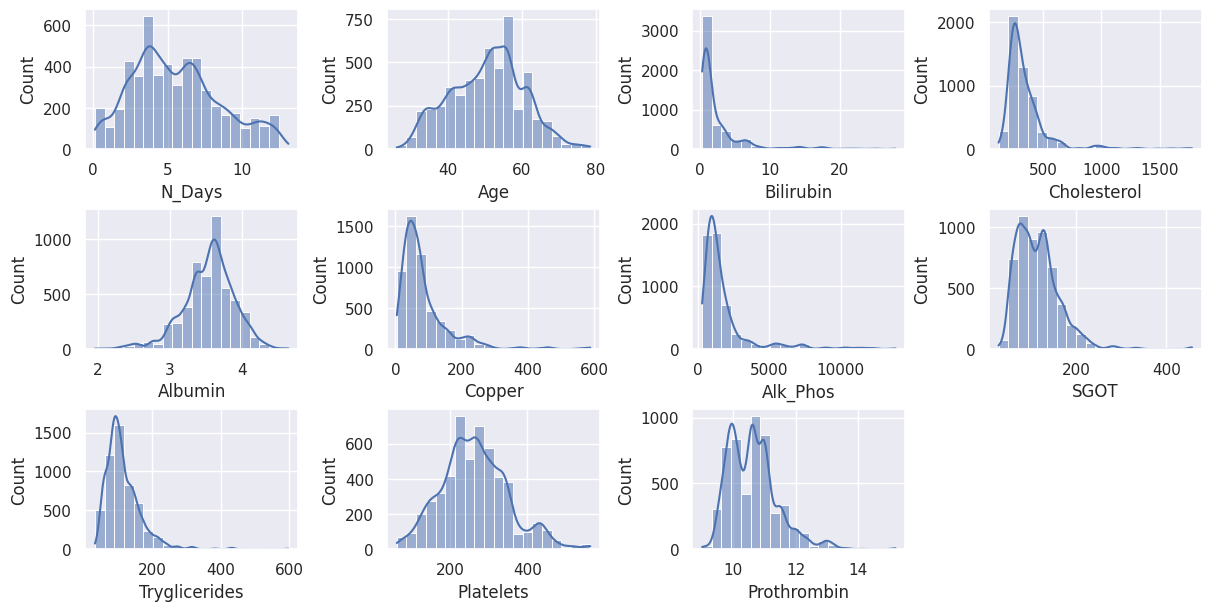

In [13]:
fig = plt.figure(figsize=(12,6), layout='constrained')
test_num_features = test_df.select_dtypes(np.number)
test_num_features[['N_Days', 'Age']] = days_to_years(test_num_features, ['N_Days', 'Age'])

for i, col in enumerate(test_num_features.iloc[:, :-1], 1):
    fig.add_subplot(3,4,i)
    sns.histplot(test_num_features[col], bins=20, kde=True)


## Numerical features correlations

<Axes: >

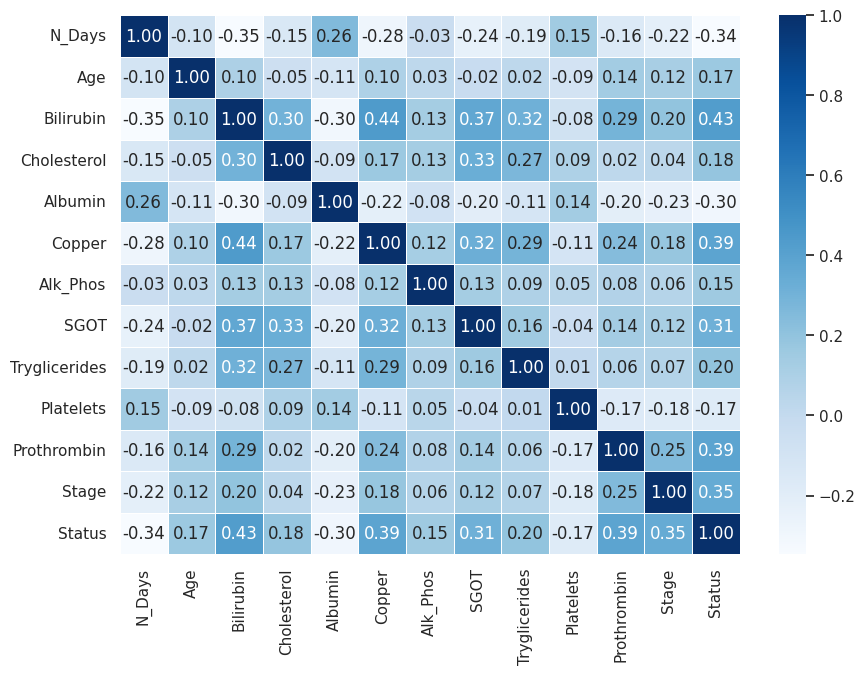

In [14]:
fig = plt.figure(figsize=(10,7))
status = eda_cat_features['Status'].map({'C':0, 'CL':1, 'D':2})
eda_num_status = pd.concat([eda_num_features, status], axis=1)
sns.heatmap(eda_num_status.corr(),annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

## OHE categorical features

In [15]:
# encoded_features = pd.concat([eda_num_features,
#                               pd.get_dummies(eda_cat_features.iloc[:,:-1], dtype='int32')], axis=1)
# encoded_features

## Make baseline

In [16]:
# score1 = get_cv_score(encoded_features, status).mean()
# score2 = get_cv_score(eda_num_features, status).mean()
# #0.4846
# print(score1)
# #0.4858
# print(score2)

In [17]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# X_train, X_val, y_train, y_val = train_test_split(encoded_features, status, stratify=status)

# xgb_params = {'max_depth': 5,
#  'min_child_weight': 8, 
#  'learning_rate': 0.10450346600896168,
#  'n_estimators': 225,
#  'subsample': 0.5855025206558809,
#  'colsample_bytree': 0.14926372575849994,
#  'reg_alpha': 0.7621405624015435, 
#  'reg_lambda': 0.6443164876665903,}


# model = xgb.XGBClassifier(**xgb_params)
# model.fit(X_train, y_train)
# preds_proba = model.predict_proba(X_val)
# preds = model.predict(X_val)

# print(log_loss(y_val, preds_proba))
# print(f1_score(y_val, preds, average='weighted'))

### 1. Optuna + XGBoost + One Hot Encoding data

In [18]:
# study = tuning_xgb(encoded_features, status)

In [19]:
# p = {'n_estimators':170,
#      'max_depth': 7,
#      'min_child_weight': 3,
#      'learning_rate': 0.09481013111513892,
#      'subsample': 0.6,
#      'colsample_bytree': 0.10287736645803192}

# model = xgb.XGBClassifier(**p)
# model.fit(encoded_features, status)


## One side 95% winsorization of outliers (not used)

### 2. Optuna + XGBoost + One Hot Encoding data + winsorized data

In [20]:
# data = eda_num_features.copy()
# upper_bounds = data.quantile(0.99)

# for i, col in enumerate(data):
#     for j, val_j in enumerate(data[col]):
#         if val_j >= upper_bounds[i]:
#             data.iloc[j, i] = upper_bounds[i]

# data = pd.concat([data, pd.get_dummies(eda_cat_features.iloc[:,:-1], dtype='int32')], axis=1)


# study = tuning_xgb(data, status)

# get_cv_score(data, status).mean()

## Create polynomial features (not used)

In [21]:
# from sklearn.preprocessing import PolynomialFeatures

# data = eda_num_features
# target = status[data.index]

# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# data_poly = poly.fit_transform(data)

# print("Original data: ",get_cv_score(data, target).mean())
# print("Polynomial data: ",get_cv_score(data_poly, target).mean())



In [22]:
# data = encoded_features.copy()

# data['bi_cho'] = data['Bilirubin'] - data['Cholesterol'] * .5

# model = xgb.XGBClassifier(**xgb_params)
# model.fit(data, status)


# get_cv_score(data, status).mean()

In [23]:
# xgb.plot_importance(model, importance_type='weight',
#                     title='Feature Importances',
#                     xlabel='Weight',
#                     ylabel='Features',)

In [24]:
# test_df[['N_Days', 'Age']] = days_to_years(test_df, ['N_Days', 'Age'])
# test_num_features = test_df.select_dtypes(np.number)
# test_cat_features = test_df.select_dtypes('object')

# encoded_features = pd.concat([test_num_features,
#                               pd.get_dummies(test_cat_features, dtype='int32')], axis=1)

# y_pred = model.predict_proba(encoded_features)
# y_pred = pd.DataFrame(y_pred)
# y_pred.columns = ['Status_C', 'Status_CL','Status_D']
# y_pred.head()

# submission_df = pd.DataFrame()
# submission_df = y_pred  
# submission_df['id'] = test_df.index
# submission_df['id'] = submission_df['id'].apply(lambda x : int(x))

# submission_df.to_csv('submission.csv', index= False)